<a href="https://colab.research.google.com/github/shlokster/AlgoTrading/blob/main/LogisticRegression_AlgoTrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

When you are running it for the first time uncomment the dependencies and execute. Once they are downloaded you wont need to download it again so you can comment it again.

Note: The installation can take 3 minutes or so depending on your system.

In [20]:
import numpy as np
import pandas as pd
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# !tar -xzvf ta-lib-0.4.0-src.tar.gz
# %cd ta-lib
# !./configure --prefix=/usr
# !make
# !make install
# !pip install Ta-Lib
import talib as ta

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from pandas_datareader import data as pdr
# !pip3 install yfinance
import yfinance as yf


In [99]:
yf.pdr_override()

df = pdr.get_data_yahoo('^NSEI', '2000-01-01', '2018-01-01')
df = df.dropna()
df = df.iloc[:,:4]
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close
Date,,,,
2007-09-17,4518.450195,4549.049805,4482.850098,4494.649902
2007-09-18,4494.100098,4551.799805,4481.549805,4546.200195
2007-09-19,4550.250000,4739.000000,4550.250000,4732.350098
2007-09-20,4734.850098,4760.850098,4721.149902,4747.549805
2007-09-21,4752.950195,4855.700195,4733.700195,4837.549805


In [100]:
df['S_10'] = df['Close'].rolling(window=10).mean()
df['Corr'] = df['Close'].rolling(window=10).corr(df['S_10'])
df['RSI'] = ta.RSI(np.array(df['Close']), timeperiod =10)
df['Open-Close'] = df['Open'] - df['Close'].shift(1)
df['Open-Open'] = df['Open'] - df['Open'].shift(1)
df = df.dropna()
X = df.iloc[:,:9]


y = np.where(df['Close'].shift(-1) > df['Close'],1,-1)

split = int(0.7*len(df))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

model = LogisticRegression()
model = model.fit (X_train,y_train)

pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

probability = model.predict_proba(X_test)

predicted = model.predict(X_test)
# print(metrics.classification_report(y_test, predicted))

print(model.score(X_test,y_test))

cross_val = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
# print(cross_val)
# print(cross_val.mean())


0.5266666666666666


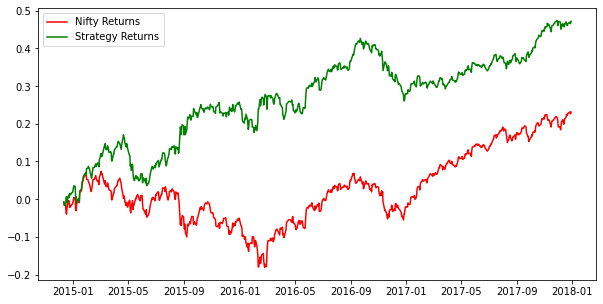

In [101]:
df['Predicted_Signal'] = model.predict(X)
df['Nifty_returns'] = np.log(df['Close']/df['Close'].shift(1))
Cumulative_Nifty_returns = np.cumsum(df[split:]['Nifty_returns'])

df['Startegy_returns'] = df['Nifty_returns']* df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = np.cumsum(df[split:]['Startegy_returns'])

plt.figure(figsize=(10,5))
plt.plot(Cumulative_Nifty_returns, color='r',label = 'Nifty Returns')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()


Trying to Improve accuracy and making it fit different datasets here

In [102]:

close = df['Close'].values

def split_sequences(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X,y = split_sequences(close,10)
new_y = []
for i in range(1,len(y)):
    if y[i] > y[i-1]:
        new_y.append(0)
    elif y[i] < y[i-1]:
        new_y.append(1)
    else:
        new_y.append(0)
        
X = np.array(X)[1:]
y = np.array(new_y)
for i in range(len(X)):
    X[i] = np.array(X[i])

from keras.models import Sequential
from keras import callbacks
from keras.layers import Dense, BatchNormalization,Reshape,Dropout
from keras.models import Sequential, load_model, model_from_json

# import os
# h5 = 'binary' + '_best_model' + '.h5'
# checkpoint = callbacks.ModelCheckpoint(h5,
#                                         monitor='val_loss',
#                                         verbose=0,
#                                         save_best_only=True,
#                                         save_weights_only=True,
#                                         mode='auto',
#                                         period=1)
# callback = [checkpoint]
# json = 'binary' + '_best_model' + '.json'
# model_json = model.to_json()
# with open(json, "w") as json_file:
#     json_file.write(model_json)
# model.fit(X,y,epochs = 1000,verbose = 2,validation_split = 0.2,callbacks = [callback])

def estimate_profits(pred,y):
    profits = 0
    investment = 100
    log = []
    for i in range(len(y)-1):
        if round(pred[i][0]) == 1:
            trade = 'buy'
        elif round(pred[i][0]) == 0:
            trade = 'sell'
        else:
            trade = None
        if y[i+1] == 1:
            correct_trade = 'buy'
        elif y[i+1] == 0:
            correct_trade = 'sell'
        else:
            correct_trade = None
        if correct_trade:
            if trade == correct_trade:
                profits += 0.8*investment
                log.append(1)
            else:
                profits -= investment
                log.append(0)
    accuracy = round(log.count(1)/len(log)*100)
    return profits,accuracy

model = Sequential()
model.add(Dense(100,input_shape = (None,10)))
model.add(Dense(1024,activation = 'relu'))
model.add(Dense(1024,activation = 'relu'))
model.add(Dense(1024,activation = 'relu'))
model.add(Dense(1,activation = 'sigmoid'))
model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = 'accuracy')


# model = Sequential()
# model.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
# model.add(TimeDistributed(MaxPooling1D(pool_size=2, strides=None)))
# model.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu')))
# model.add(TimeDistributed(MaxPooling1D(pool_size=2, strides=None)))
# model.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu')))
# model.add(TimeDistributed(MaxPooling1D(pool_size=2, strides=None)))
# model.add(TimeDistributed(Conv1D(filters=128, kernel_size=1, activation='relu')))
# model.add(TimeDistributed(Flatten()))
# model.add(LSTM(128,return_sequences = True))
# model.add(LSTM(64))
# model.add(BatchNormalization())
# model.add(Dense(1,activation = 'sigmoid'))
# model.compile(optimizer=optimizer, loss='mse')

def normalize_data(dataset):
        cols = dataset.columns.tolist()
        col_name = [0]*len(cols)
        for i in range(len(cols)):
            col_name[i] = i
        dataset.columns = col_name
        dtypes = dataset.dtypes.tolist()
        minmax = list()
        for column in dataset:
            dataset = dataset.astype({column: 'float32'})
        for i in range(len(cols)):
            col_values = dataset[col_name[i]]
            value_min = min(col_values)
            value_max = max(col_values)
            minmax.append([value_min, value_max])
        for column in dataset:
            values = dataset[column].values
            for i in range(len(values)):
                values[i] = (values[i] - minmax[column][0]) / (minmax[column][1] - minmax[column][0])
            dataset[column] = values
        dataset[column] = values
        return dataset,minmax

# normalize_data(df)